# Preparation

In [1]:
import pandas as pd              # For data manipulation and analysis
import numpy as np               # For numerical computing
from datetime import datetime
from scipy.stats import trim_mean, kurtosis, skew, boxcox, yeojohnson      # For statistical analysis
from math import sqrt
import matplotlib                # For plotting and visualization
import matplotlib.pyplot as plt  
from pandas.plotting import parallel_coordinates
import seaborn as sns            # For statistical data visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# For machine learning

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score,
                             f1_score, confusion_matrix, classification_report)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv', index_col = 0)
df_test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv', index_col = 0)

# Exploratory Data Analysis

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [5]:
df_train.describe(include = 'all').T.style

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,11504798,2,Male,6228134,nan,nan,nan,nan,nan,nan,nan
Age,11504798.000000,nan,nan,nan,38.383563,14.993459,20.000000,24.000000,36.000000,49.000000,85.000000
Driving_License,11504798.000000,nan,nan,nan,0.998022,0.044431,0.000000,1.000000,1.000000,1.000000,1.000000
Region_Code,11504798.000000,nan,nan,nan,26.418690,12.991590,0.000000,15.000000,28.000000,35.000000,52.000000
Previously_Insured,11504798.000000,nan,nan,nan,0.462997,0.498629,0.000000,0.000000,0.000000,1.000000,1.000000
Vehicle_Age,11504798,3,1-2 Year,5982678,nan,nan,nan,nan,nan,nan,nan
Vehicle_Damage,11504798,2,Yes,5783229,nan,nan,nan,nan,nan,nan,nan
Annual_Premium,11504798.000000,nan,nan,nan,30461.370411,16454.745205,2630.000000,25277.000000,31824.000000,39451.000000,540165.000000
Policy_Sales_Channel,11504798.000000,nan,nan,nan,112.425442,54.035708,1.000000,29.000000,151.000000,152.000000,163.000000
Vintage,11504798.000000,nan,nan,nan,163.897744,79.979531,10.000000,99.000000,166.000000,232.000000,299.000000


Observations:
- Train data 11,504,798 rows x 11 columns (10 features & 1 Target).
- Dataset includes categorical and numerical data in object, int64, and float64.
- Categorical features are `Gender`, `Vehicle_Age`, `Vehicle_Damage`
- Discrete Numerical features are`Driving_License`, `Region_Code`, `Previously_Insured`, `Policy_Sales_Channel`, `Vintage`
- Continuous Numerical features are `Annual_Premium`, `Age`

Actions:
- Explore the distributions of each feature within and in correlation with each other
- Explore `Policy_Sales_Channel` & `Vintage` because I am unsure what information this feature conveys

# Data Visualization

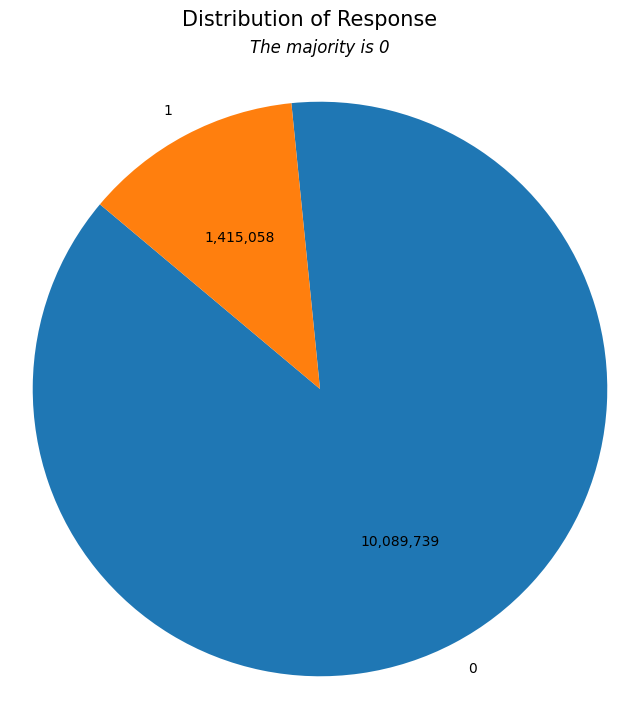

In [6]:
response_counts = df_train['Response'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(response_counts, labels=response_counts.index, autopct=lambda p: f'{int(p * sum(response_counts) / 100):,}', startangle=140)
plt.suptitle('Distribution of Response', fontsize = 15)
plt.subplots_adjust(top=0.9)
plt.title('The majority is 0', y = 1.02, style = 'italic')
plt.axis('equal') 
plt.show()


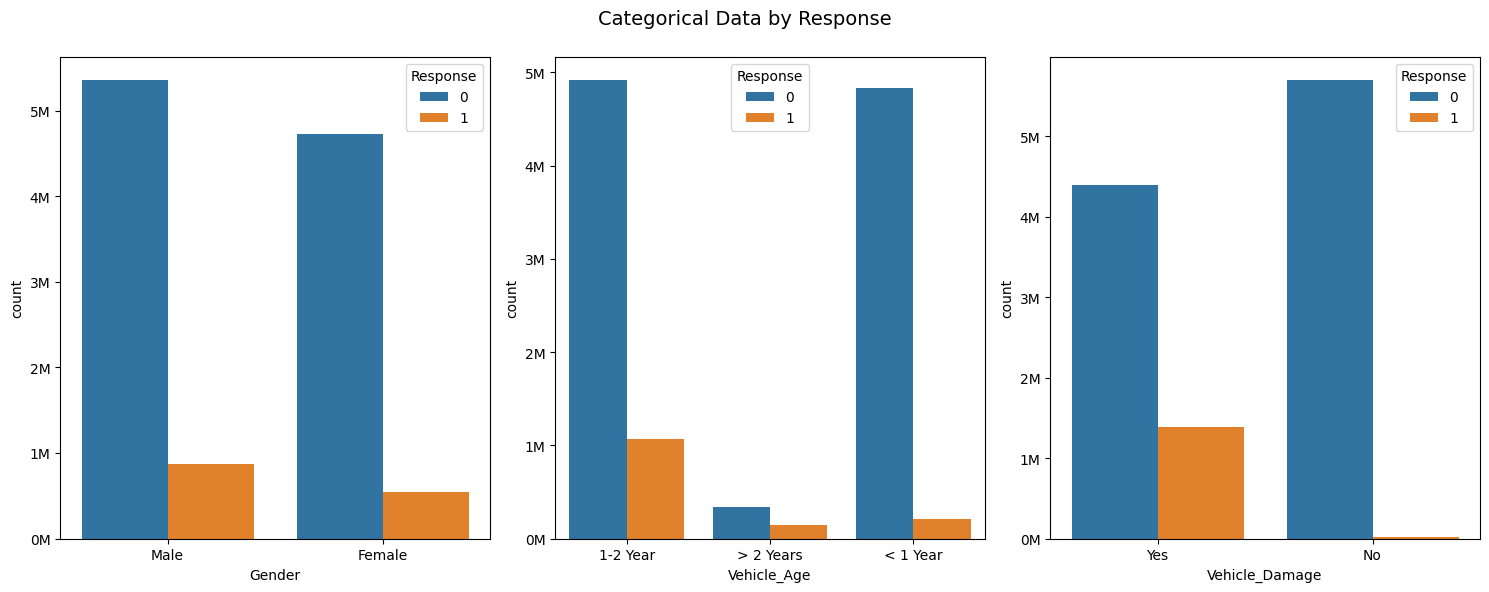

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))  

# Loop through the specified columns and create count plots
for i, column in enumerate(['Gender', 'Vehicle_Age', 'Vehicle_Damage']):
    plt.subplots_adjust(top=0.85)
    ax = sns.countplot(data=df_train, 
                       x=column, 
                       hue='Response', 
                       ax=axes[i % 3])
    ax.set_yticklabels(['{:,.0f}M'.format(ticks / 1000000) for ticks in ax.get_yticks()])

fig.tight_layout(h_pad=2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Categorical Data by Response', fontsize=14)
plt.show()

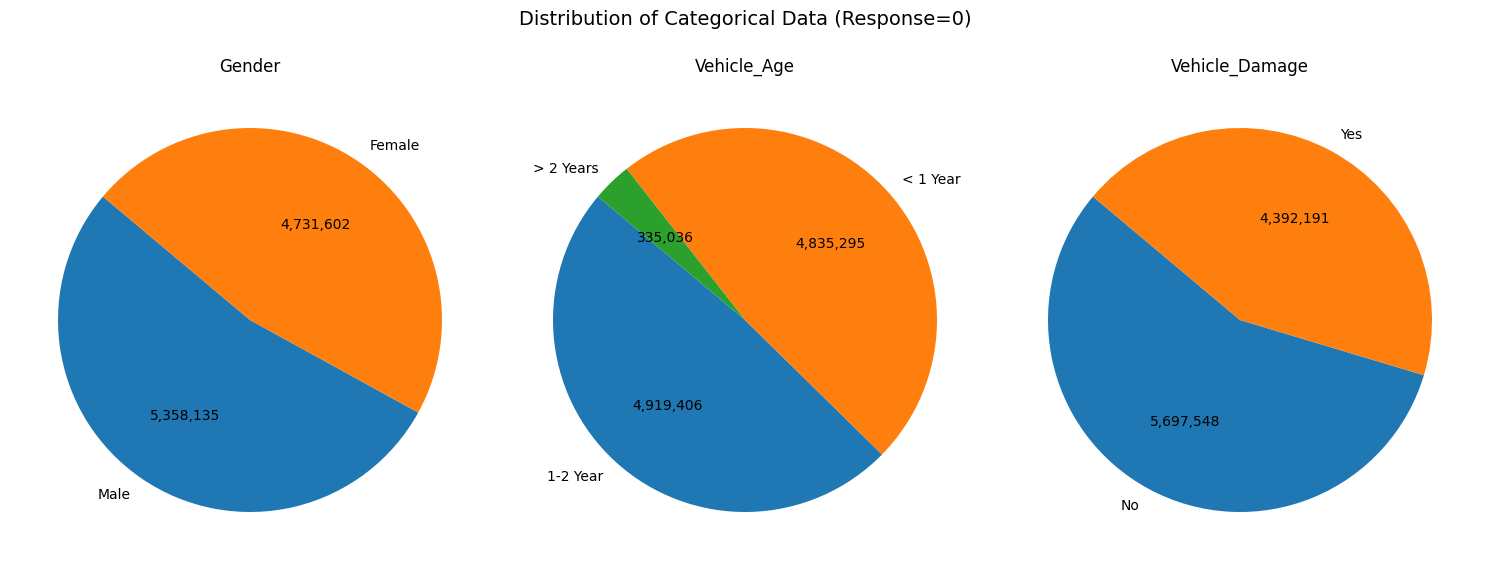

In [8]:
# Filter the DataFrame for rows where Response is 0
df_response_0 = df_train[df_train['Response'] == 0]

# List of columns to create pie charts for
columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Loop through the specified columns and create pie charts
for i, column in enumerate(columns):
    plt.subplots_adjust(top=0.85)
    
    # Calculate the distribution for the current column
    counts = df_response_0[column].value_counts()
    
    # Create a pie chart
    axes[i].pie(counts, labels=counts.index, autopct=lambda p: f'{int(p * sum(counts) / 100):,}', startangle=140)
    axes[i].set_title(f'{column}', fontsize=12)

fig.tight_layout(h_pad=2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Categorical Data (Response=0)', fontsize=14)
plt.show()

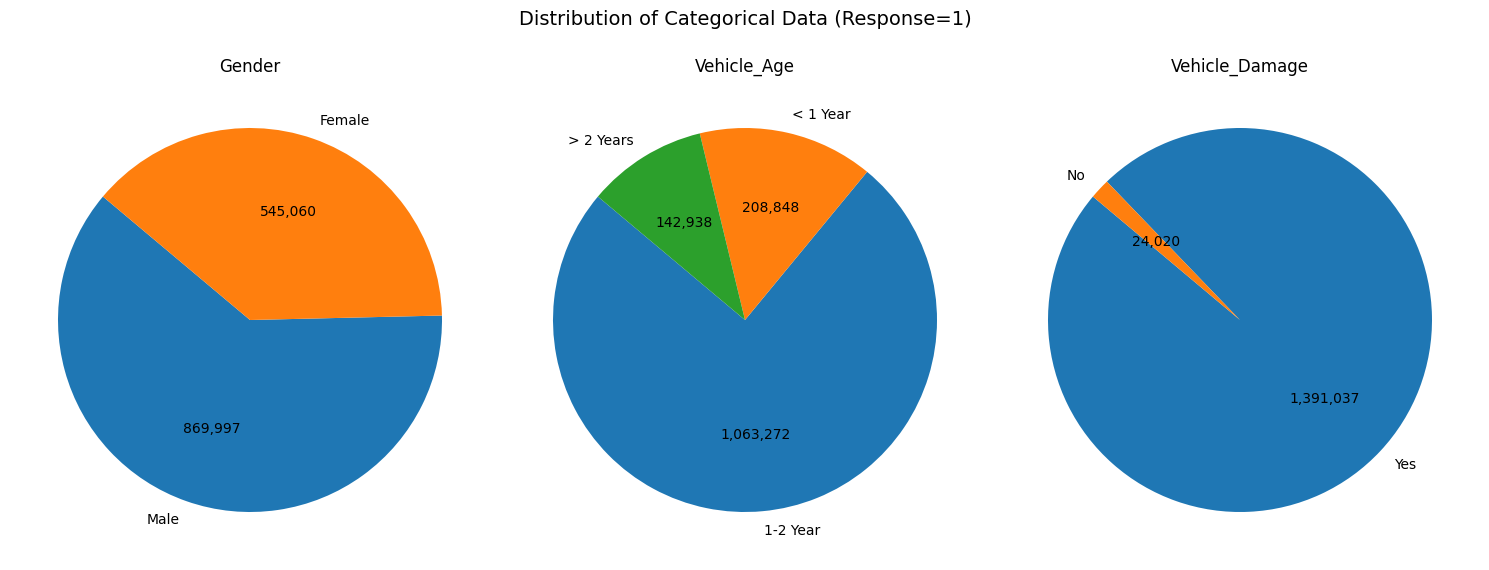

In [9]:
# Filter the DataFrame for rows where Response is 0
df_response_1 = df_train[df_train['Response'] == 1]

# List of columns to create pie charts for
columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Loop through the specified columns and create pie charts
for i, column in enumerate(columns):
    plt.subplots_adjust(top=0.85)
    
    # Calculate the distribution for the current column
    counts = df_response_1[column].value_counts()
    
    # Create a pie chart
    axes[i].pie(counts, labels=counts.index, autopct=lambda p: f'{int(p * sum(counts) / 100):,}', startangle=140)
    axes[i].set_title(f'{column}', fontsize=12)

fig.tight_layout(h_pad=2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Categorical Data (Response=1)', fontsize=14)
plt.show()

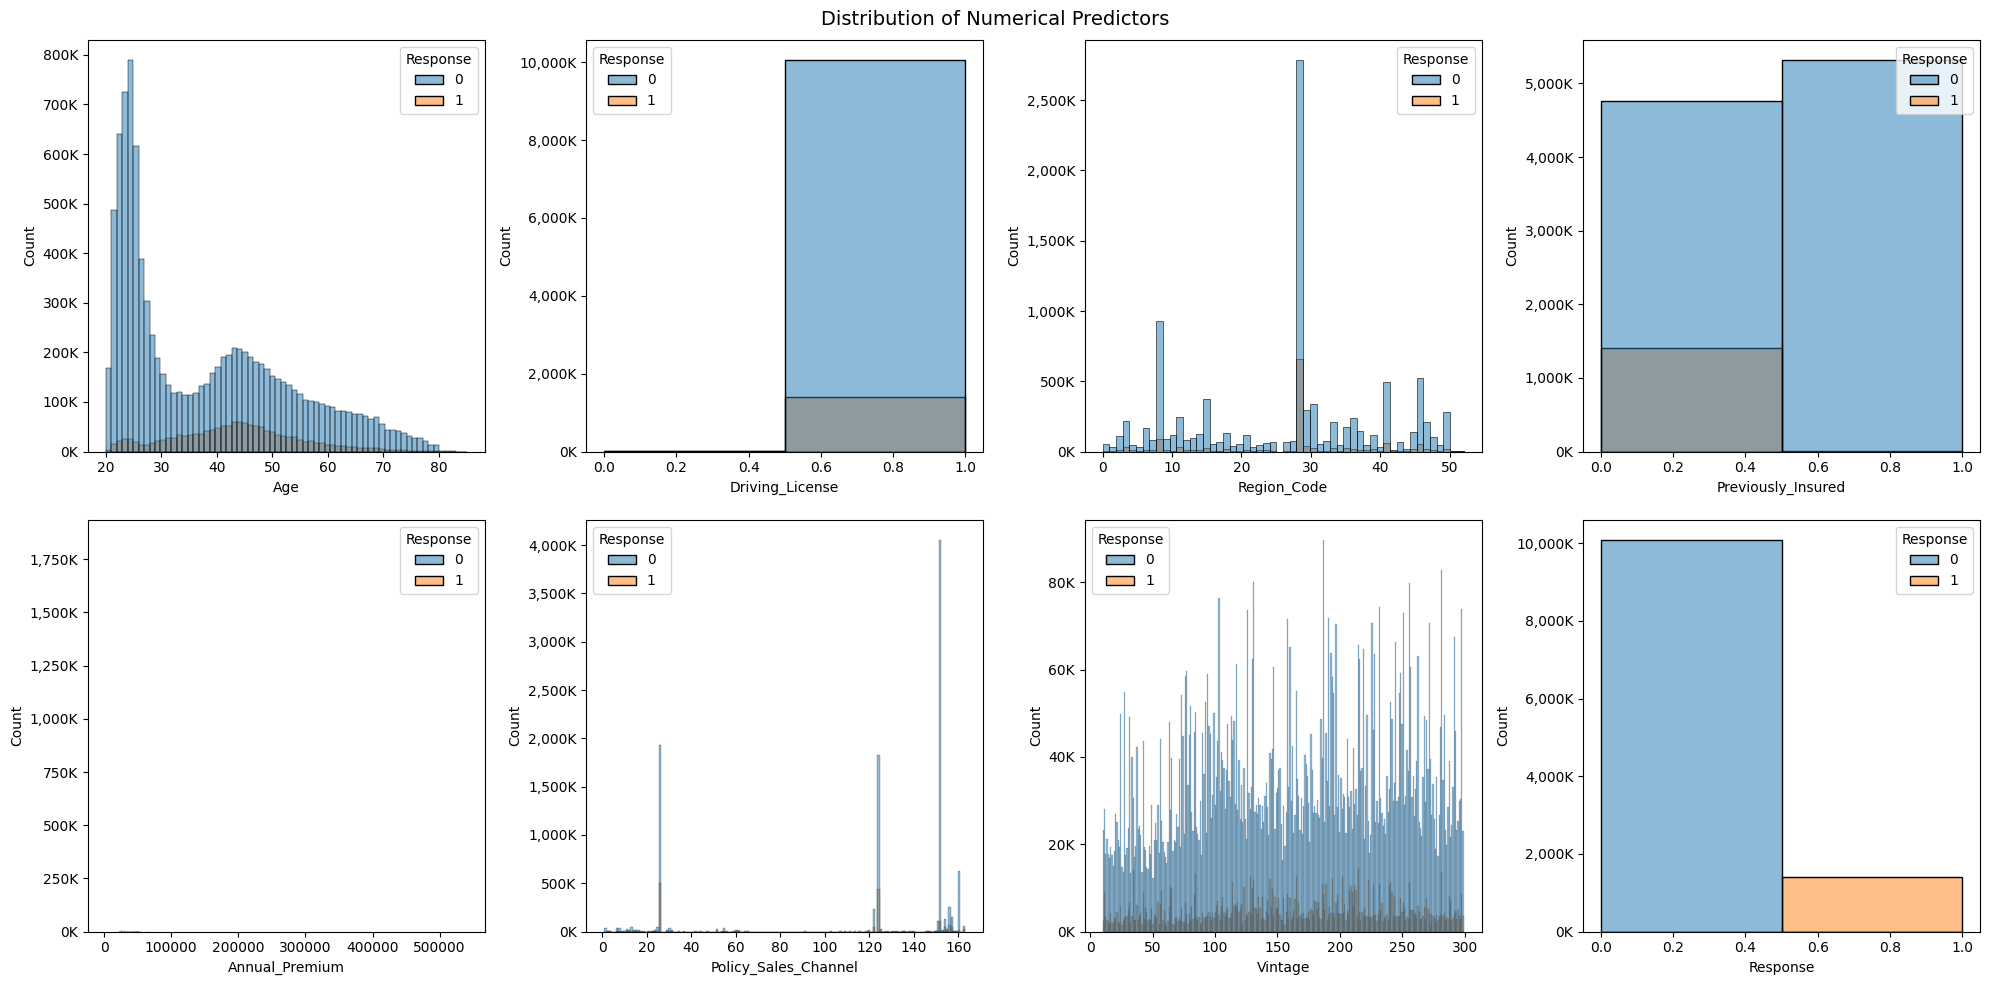

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
 
for i, column in enumerate(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured','Annual_Premium',
                            'Policy_Sales_Channel', 'Vintage', 'Response']):
    plt.subplots_adjust(top = 0.85)
    ax = sns.histplot(data = df_train, 
                x = column, 
                hue = 'Response',
                bins = df_train[column].nunique(),
                ax = axes[i // 4, i % 4])
    ax.set_yticklabels(['{:,.0f}K'.format(ticks / 1000) for ticks in ax.get_yticks()])
fig.tight_layout(h_pad = 2)
plt.subplots_adjust(top = 0.95)
plt.suptitle('Distribution of Numerical Predictors', fontsize = 14)
plt.show()

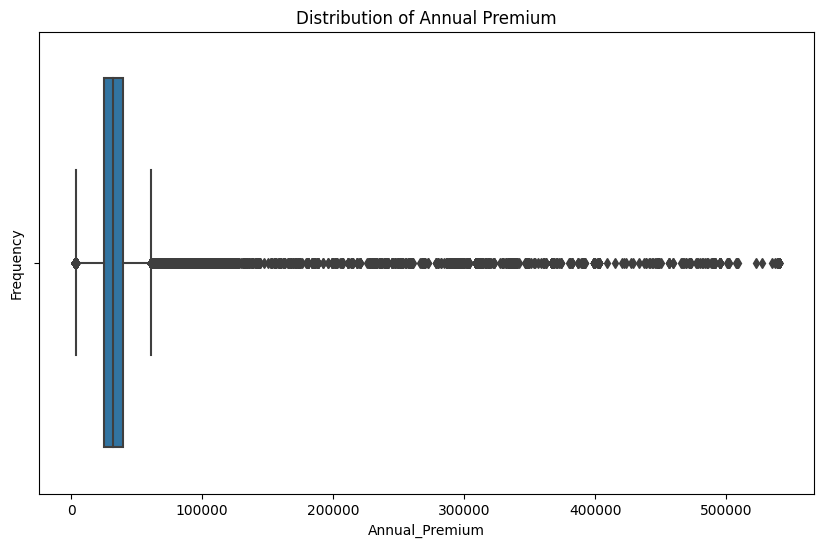

In [11]:
plt.figure(figsize=(10, 6))

sns.boxplot(x = df_train['Annual_Premium'])
plt.title('Distribution of Annual Premium')
plt.xlabel('Annual_Premium')
plt.ylabel('Frequency')
plt.show()

# Preprocessing

In [12]:
# Numerical columns: if the number of unique values is more than 8
num_cols = ['Age', 'Annual_Premium']
# Categorical columns: if the number of unique values is 8 or fewer
cat_cols = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Vintage']
print("Categorical Features", cat_cols)
print("Numerical Features", num_cols)

Categorical Features ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Vintage']
Numerical Features ['Age', 'Annual_Premium']


# Feature Engineering

In [13]:
def feature_mapping(df):
    df['Vehicle_Age'] = df['Vehicle_Age'].replace({'1-2 Year':1,
                                                   '> 2 Years':2, 
                                                   '< 1 Year':0})
    df['Gender'] = df['Gender'].replace({'Male':0,
                                         'Female':1})
    df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'Yes':1,
                                                    'No':0})
    df['Annual_Premium']=df['Annual_Premium'].astype('int')
    df['Region_Code']=df['Region_Code'].astype('int')
    return df
df_train = feature_mapping(df_train)
df_test = feature_mapping(df_test)

In [14]:
df_train['Policy_Sales_Channel']=df_train['Policy_Sales_Channel'].replace({5:np.NAN,
                                                                     6:np.NAN,
                                                                     33:np.NAN 
})
df_train['Policy_Sales_Channel']=df_train['Policy_Sales_Channel'].replace({144:np.NAN,
                                                                     149:np.NAN
})
df_test['Policy_Sales_Channel']=df_test['Policy_Sales_Channel'].replace({144:np.NAN,
                                                                     149:np.NAN
})

In [15]:
for i in ['Region_Code','Policy_Sales_Channel']:
    if (len(list(set(df_train[i].dropna().unique().tolist())^set(df_test[i].dropna().unique().tolist())))!=0):
        print(i ,'need to be worked on')
    else:
        continue
print('Done')

Done


In [16]:
df_train['Policy_Sales_Channel']=df_train['Policy_Sales_Channel'].fillna(-1)
df_test['Policy_Sales_Channel']=df_test['Policy_Sales_Channel'].fillna(-1)
df_train['Policy_Sales_Channel']=df_train['Policy_Sales_Channel'].astype('int')
df_test['Policy_Sales_Channel']=df_test['Policy_Sales_Channel'].astype('int')
len(sorted(df_train['Policy_Sales_Channel'].unique().tolist())),len(sorted(df_test['Policy_Sales_Channel'].unique().tolist()))

(150, 150)

In [17]:
# # Categorical columns: if the number of unique values is 5 or fewer
# cat_cols = [col for col in df_test.columns if df_test[col].nunique() <= 5]
# # Numerical columns: if the number of unique values is 6 or more
# num_cols = [col for col in df_test.columns if df_test[col].nunique() > 5]
# print("Categorical Features", cat_cols)
# print("Numerical Features", num_cols)

## Split Data

In [18]:
X = df_train.drop(columns = ['Response'] , axis = 1)
y = df_train['Response']

## Frequency Encoder

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.frequency_maps = {}

    def fit(self, X, y=None):
        for column in self.columns:
            frequency = X[column].value_counts()
            self.frequency_maps[column] = frequency
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.columns:
            X_transformed[column + '_freq'] = X_transformed[column].map(self.frequency_maps[column])
        return X_transformed

In [20]:
# Define columns for frequency encoding
freq_cols = ['Vintage', 'Policy_Sales_Channel']

# Define numerical and categorical columns (excluding freq_cols as they will be handled separately)
num_cols = [col for col in df_test.columns if (col not in freq_cols) & (df_test[col].nunique() > 5)]
cat_cols = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

# Initialize FrequencyEncoder with the specified columns
freq_encoder = FrequencyEncoder(columns=freq_cols)

# Fit the frequency encoder to the data
freq_encoder.fit(X)

# Transform the data to include frequency encoded columns
X_freq_encoded = freq_encoder.transform(X)
df_test_freq_encoded = freq_encoder.transform(df_test)

# Define the preprocessing for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('freq', 'passthrough', [col + '_freq' for col in freq_cols])
    ])

# Fit and transform the training data
X_processed = preprocessor.fit_transform(X_freq_encoded)
df_test_processed = preprocessor.transform(df_test_freq_encoded)

# Convert processed arrays back to DataFrames
X_processed = pd.DataFrame(X_processed, columns=preprocessor.get_feature_names_out())
df_test_processed = pd.DataFrame(df_test_processed, columns=preprocessor.get_feature_names_out())

# Keep dataframe names consistent
X = X_processed
df_test = df_test_processed

In [21]:
# # Define the preprocessing for numerical and categorical columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), num_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
#     ])

# # Fit and transform the training data
# X_processed = preprocessor.fit_transform(X)
# df_test_processed = preprocessor.transform(df_test)

# # Convert processed arrays back to DataFrames
# X_processed = pd.DataFrame(X_processed, columns=preprocessor.get_feature_names_out())
# df_test_processed = pd.DataFrame(df_test_processed, columns=preprocessor.get_feature_names_out())

# # Keep dataframe names consistent
# X = X_processed
# df_test = df_test_processed

# Machine Learning

In [22]:
# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Define a function to clean the column names
def clean_column_names(df):
    df.columns = df.columns.str.replace('[', '', regex=False)
    df.columns = df.columns.str.replace(']', '', regex=False)
    df.columns = df.columns.str.replace('<', '', regex=False)
    df.columns = df.columns.str.replace('>', '', regex=False)
    return df

# Apply the function to your DataFrames
X_train = clean_column_names(X_train)
X_valid = clean_column_names(X_valid)
df_test = clean_column_names(df_test)

In [24]:
# Ensure that the indices are reset
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
#df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## XGBoost

In [25]:
# import optuna
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import roc_auc_score

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'booster': 'gbtree',
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'random_state': 0
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#     # Train XGBoost model with current hyperparameters
#     clf = XGBClassifier(**params)
#     clf.fit(X_train_split, y_train_split)

#     # Predict probabilities on validation set
#     y_pred_proba = clf.predict_proba(X_valid_split)[:, 1]

#     # Calculate ROC AUC on validation set
#     roc_auc = roc_auc_score(y_valid_split, y_pred_proba)
#     return roc_auc

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=15)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

Best parameters: 
> {'max_depth': 10, 'learning_rate': 0.0606845289046377, 'min_child_weight': 3.353597655283031, 'colsample_bytree': 0.9968421557913516, 'reg_alpha': 3.4949651852834847, 'reg_lambda': 2.7788715193707647, 'subsample': 0.9838238624678215, 'n_estimators': 993}. Best is trial 12 with value: 0.8871492329232011.


In [26]:
# best_params = {'booster': 'gbtree',
#                'objective': 'binary:logistic',
#                'eval_metric': 'auc',
#                'device':'cuda',
#                'max_depth': 10,
#                'learning_rate': 0.0606845289046377, 
#                'min_child_weight': 3.353597655283031, 
#                'colsample_bytree': 0.9968421557913516, 
#                'reg_alpha': 3.4949651852834847, 
#                'reg_lambda': 2.7788715193707647, 
#                'subsample': 0.9838238624678215, 
#                'n_estimators': 1500,
#                'random_state': 0}

# # Create the XGBoost model using Optuna model
# xgb_1 = XGBClassifier(**best_params)

# # Perform cross-validation
# cv_scores = cross_val_score(xgb_1, X_train, y_train, cv=5, scoring='roc_auc')

# # Print CV scores
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", cv_scores.mean())

# # Fit the model on the full training data
# xgb_1.fit(X_train, y_train)

# # Predict probabilities on validation data
# y_pred_proba_xgb_1 = xgb_1.predict_proba(X_valid)[:, 1]

# # Calculate ROC AUC on validation data
# roc_auc = roc_auc_score(y_valid, y_pred_proba_xgb_1)
# print("ROC AUC on Validation Data:", roc_auc) # 0.8805

In [27]:
#https://www.kaggle.com/code/anshulm257/blend-xgb-cat-tuned-hyperparameters
best_params = {    
    'alpha': 1.302348865795227e-06, 
    'max_depth': 15, 
    'learning_rate': 0.061800451723613786, 
    'subsample': 0.7098803046786328, 
    'colsample_bytree': 0.2590672912533101, 
    'min_child_weight': 10, 
    'gamma': 0.8399887056014855, 
    'reg_alpha': 0.0016943548302122801, 
    'n_estimators': 12000,
    'max_bin': 71284,
    'device': 'cuda',
    'eval_metric': 'auc'}

# Split the training data to include a validation set for early stopping
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Create the XGBoost model using Optuna model
xgb_1 = XGBClassifier(**best_params)

# Fit the model with early stopping
xgb_1.fit(X_train_split, y_train_split,
          eval_set=[(X_valid_split, y_valid_split)],
          early_stopping_rounds=100,
          verbose=500)

# Predict probabilities on validation data
y_pred_proba_xgb_1 = xgb_1.predict_proba(X_valid)[:, 1]

# Calculate ROC AUC on validation data
roc_auc = roc_auc_score(y_valid, y_pred_proba_xgb_1)
print("ROC AUC on Validation Data:", roc_auc) #0.8914389507197454

[0]	validation_0-auc:0.82868
[500]	validation_0-auc:0.88769
[1000]	validation_0-auc:0.88939
[1500]	validation_0-auc:0.89035
[2000]	validation_0-auc:0.89085
[2500]	validation_0-auc:0.89112
[3000]	validation_0-auc:0.89129
[3500]	validation_0-auc:0.89142
[4000]	validation_0-auc:0.89154
[4500]	validation_0-auc:0.89162
[5000]	validation_0-auc:0.89168
[5061]	validation_0-auc:0.89168
ROC AUC on Validation Data: 0.8914389507197454


## CatBoost

In [28]:
# import optuna
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import roc_auc_score

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'border_count': trial.suggest_int('border_count', 1, 255),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0),
#         'eval_metric': 'AUC',
#         'random_state': 0
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#     # Train CatBoost model with current hyperparameters
#     clf = CatBoostClassifier(**params)
#     clf.fit(X_train_split, y_train_split, eval_set=(X_valid_split, y_valid_split), verbose=0, early_stopping_rounds=50)

#     # Predict probabilities on validation set
#     y_pred_proba = clf.predict_proba(X_valid_split)[:, 1]

#     # Calculate ROC AUC on validation set
#     roc_auc = roc_auc_score(y_valid_split, y_pred_proba)
#     return roc_auc

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=15)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

Best parameters: 
> {'iterations': 676, 'depth': 8, 'learning_rate': 0.28984500728780294, 'random_strength': 9.898408041261492, 'bagging_temperature': 0.16341603690391523, 'border_count': 251, 'l2_leaf_reg': 41.766508987970674, 'scale_pos_weight': 0.4668901949008498}.


In [29]:
# from catboost import CatBoostClassifier
# best_params = {
#     'iterations': 676,
#     'depth': 8,
#     'learning_rate': 0.2898450072878029,
#     'random_strength': 9.898408041261492,
#     'bagging_temperature': 0.16341603690391523,
#     'border_count': 251,
#     'l2_leaf_reg': 41.766508987970674,
#     'scale_pos_weight': 0.4668901949008498,
#     'eval_metric': 'AUC',
#     'random_state': 0,
#     'verbose' : 100,
# }

# # Create CatBoost model with the best hyperparameters
# cat_1 = CatBoostClassifier(**best_params)

# # Perform cross-validation
# cv_scores = cross_val_score(cat_1, X_train, y_train, cv=5, scoring='roc_auc')

# # Print CV scores
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", cv_scores.mean())

# # Fit the model on the full training data
# cat_1.fit(X_train, y_train)

# # Predict probabilities on validation data
# y_pred_proba_cat_1 = cat_1.predict_proba(X_valid)[:, 1]

# # Calculate ROC AUC on validation data
# roc_auc = roc_auc_score(y_valid, y_pred_proba_cat_1)
# print("ROC AUC on Validation Data:", roc_auc) #0.8806325118931165

In [30]:
from catboost import CatBoostClassifier
best_params = {
    'iterations': 5000,
    'depth': 9,
    'learning_rate': 0.05,
    'random_strength': 0,
    'bagging_temperature': 0.16341603690391523,
    'border_count': 251,
    'l2_leaf_reg': 0.5,
    'scale_pos_weight': 0.4668901949008498,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'random_state': 0,
    'verbose' : 500,
}

# Split the training data to include a validation set for early stopping
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# # Create the CatBoost model using Optuna model
cat_1 = CatBoostClassifier(**best_params)

# Fit the model with early stopping
cat_1.fit(X_train_split, y_train_split,
          eval_set=[(X_valid_split, y_valid_split)],
          early_stopping_rounds=100,
          verbose=500)

# Predict probabilities on validation data
y_pred_proba_cat_1 = cat_1.predict_proba(X_valid)[:, 1]

# Calculate ROC AUC on validation data
roc_auc = roc_auc_score(y_valid, y_pred_proba_cat_1)
print("ROC AUC on Validation Data:", roc_auc)

0:	test: 0.8534969	best: 0.8534969 (0)	total: 1.52s	remaining: 2h 7m 2s
500:	test: 0.8757854	best: 0.8757854 (500)	total: 10m 5s	remaining: 1h 30m 35s
1000:	test: 0.8784585	best: 0.8784585 (1000)	total: 20m 2s	remaining: 1h 20m 5s
1500:	test: 0.8794410	best: 0.8794410 (1500)	total: 30m 4s	remaining: 1h 10m 7s
2000:	test: 0.8799458	best: 0.8799458 (2000)	total: 40m 17s	remaining: 1h 22s
2500:	test: 0.8802598	best: 0.8802598 (2499)	total: 50m 29s	remaining: 50m 27s
3000:	test: 0.8804831	best: 0.8804831 (3000)	total: 1h 44s	remaining: 40m 27s
3500:	test: 0.8806226	best: 0.8806226 (3500)	total: 1h 10m 54s	remaining: 30m 21s
4000:	test: 0.8807188	best: 0.8807190 (3992)	total: 1h 21m 7s	remaining: 20m 15s
4500:	test: 0.8807691	best: 0.8807695 (4488)	total: 1h 31m 15s	remaining: 10m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.880770207
bestIteration = 4517

Shrink model to first 4518 iterations.
ROC AUC on Validation Data: 0.8808051327929811


https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution

## LGBM

In [31]:
# import optuna
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score

# # Define objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to search
#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': 'auc',
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'random_state': 0
#     }

#     # Split the training data into training and validation sets
#     X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#     # Train LightGBM model with current hyperparameters
#     clf = LGBMClassifier(**params)
#     clf.fit(X_train_split, y_train_split)

#     # Predict probabilities on validation set
#     y_pred_proba = clf.predict_proba(X_valid_split)[:, 1]

#     # Calculate ROC AUC on validation set
#     roc_auc = roc_auc_score(y_valid_split, y_pred_proba)
#     return roc_auc

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=15)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)


**Best Parameters**
> {'max_depth': 6, 'num_leaves': 37, 'learning_rate': 0.2874758281584408, 'feature_fraction': 0.7327900266266381, 'bagging_fraction': 0.8578751203302502, 'bagging_freq': 7, 'reg_alpha': 6.590143132488917, 'reg_lambda': 1.0491146175537724, 'n_estimators': 552}

In [32]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

best_params = {'n_estimators': 2000,
               "verbose": -1,
               'depth': 6,
               "eval_metric": "auc",
               "early_stopping_round": 50,
               "max_bin": 262143,
               'num_leaves': 223,
               'learning_rate': 0.028095688623590447,
               'min_child_samples': 54,
               'subsample': 0.5395472919165504,
               'colsample_bytree': 0.547518064129546,
               'lambda_l1': 3.4444245446562,
               'lambda_l2': 2.87490408088595e-05}

# Split the training data to include a validation set for early stopping
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Create the XGBoost model using Optuna model
lgb_1 = LGBMClassifier(**best_params)

# Fit the model with early stopping
lgb_1.fit(
    X_train_split, y_train_split,
    eval_set=[(X_valid_split, y_valid_split)],
    callbacks=[early_stopping(50), log_evaluation(500)]
)

# Predict probabilities on validation data
y_pred_proba_lgb_1 = lgb_1.predict_proba(X_valid)[:, 1]

# Calculate ROC AUC on validation data
roc_auc = roc_auc_score(y_valid, y_pred_proba_lgb_1)
print("ROC AUC on Validation Data:", roc_auc)

Training until validation scores don't improve for 50 rounds
[500]	valid_0's binary_logloss: 0.248471
[1000]	valid_0's binary_logloss: 0.246286
[1500]	valid_0's binary_logloss: 0.245333
[2000]	valid_0's binary_logloss: 0.24477
Did not meet early stopping. Best iteration is:
[1997]	valid_0's binary_logloss: 0.24477
ROC AUC on Validation Data: 0.8894947500419943


# Ensemble

## Soft Voting

In [33]:
# Combine predictions using soft voting
y_pred_softvoting = (y_pred_proba_xgb_1 + y_pred_proba_lgb_1 + y_pred_proba_cat_1) / 3

# Calculate ROC AUC on validation data
roc_auc_softvoting = roc_auc_score(y_valid, y_pred_softvoting)
print("ROC AUC on Validation Data (Soft Voting):", roc_auc_softvoting)

ROC AUC on Validation Data (Soft Voting): 0.8902002130636733


## Weight Average

In [34]:
# Define weights for the models
weights = [0.4, 0.3, 0.3] 

# Combine predictions using weighted average
y_pred_weighted = (weights[0] * y_pred_proba_xgb_1 +
                   weights[1] * y_pred_proba_lgb_1 +
                   weights[2] * y_pred_proba_cat_1)

# Calculate ROC AUC on validation data
roc_auc_weighted = roc_auc_score(y_valid, y_pred_weighted)
print("ROC AUC on Validation Data (Weighted Average):", roc_auc_weighted)

ROC AUC on Validation Data (Weighted Average): 0.8905179552985891


# Evaluate

In [35]:
roc_auc_ensemble = {
    'Soft Voting': roc_auc_softvoting,
    'Weighted Average': roc_auc_weighted
}

print("Ensemble Accuracy:")
for method, roc in roc_auc_ensemble.items():
    print(f"{method}: {roc:.5f}")

Ensemble Accuracy:
Soft Voting: 0.89020
Weighted Average: 0.89052


# Submission

In [36]:
# Predict probabilities on test data for both models
y_pred_test_xgb = xgb_1.predict_proba(df_test)[:, 1]
y_pred_test_lgb = lgb_1.predict_proba(df_test)[:, 1]
y_pred_test_cat = cat_1.predict_proba(df_test)[:, 1]

# Combine predictions using weighted average
y_pred_test_ensemble = (weights[0] * y_pred_test_xgb +
                        weights[1] * y_pred_test_lgb +
                        weights[2] * y_pred_test_cat)
# Create submission file
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
df_sub['Response'] = y_pred_test_ensemble
df_sub.to_csv('submission_ensemble.csv', index=False)
df_sub.head()

,id,Response
0,11504798,0.004562
1,11504799,0.472499
2,11504800,0.198495
3,11504801,0.000071
4,11504802,0.060711


In [37]:
# # Predict probabilities on test data for both models
# y_pred_xgb_2 = xgb_2.predict_proba(df_test)[:, 1]

# # Create submission file
# df_sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
# df_sub['Response'] = y_pred_xgb_2
# df_sub.to_csv('submission_ensemble.csv', index=False)
# df_sub.head()

In [38]:
# # Predict probabilities on validation data
# y_pred = cat_1.predict_proba(df_test)[:, 1]

# # Create submission
# df_sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
# df_sub['Response'] = y_pred
# df_sub.to_csv('submission_ensemble.csv', index=False)
# df_sub.head()